In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### Preprocessing

In [5]:
# convert yes no to binary

binary_cols = ['default','loan','housing','y']
for col in binary_cols:
    df[col] = df[col].map({'yes':1,'no':0})  # label encoding can also be used

In [8]:
# one hot encoding (for categorical variables)

categorical_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [11]:
# converting pdays -1 value

df['pdays_contacted'] = (df['pdays'] != -1).astype(int)
df['pdays'] = df['pdays'].replace(-1, 999)


### Separating target variable and test train split

In [14]:
X = df.drop('y', axis=1)
y = df['y']

In [15]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Feature Scaling

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# Copy and scale
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scaled_cols] = scaler.fit_transform(X_train_scaled[scaled_cols])  # fit+transform
X_test_scaled[scaled_cols] = scaler.transform(X_test_scaled[scaled_cols])

### Model training and Evaluation

In [17]:
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

In [18]:
# Logistic

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
#print("Logistic Regression:\n",y_test, y_pred_lr)

ROC AUC Score: 0.501753287413901


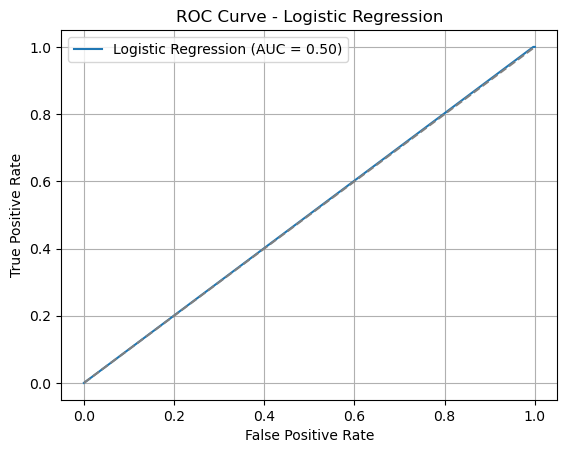

In [20]:
# ROC AUC

log_reg_probs = log_reg.predict_proba(X_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, log_reg_probs))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, log_reg_probs)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Random forest

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
#print("Random Forest:\n", y_test, y_pred_rf)

ROC AUC Score: 0.928265545156147


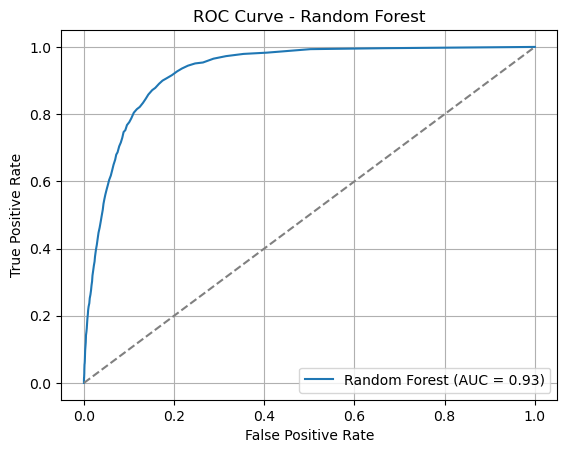

In [23]:
rf_probs = rf.predict_proba(X_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, rf_probs))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, rf_probs)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# XGBoost

from xgboost import XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
#print("XGBoost:\n",y_test, y_pred_xgb)

C:\Users\Kunal T\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:07:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC AUC Score: 0.9298683850745669


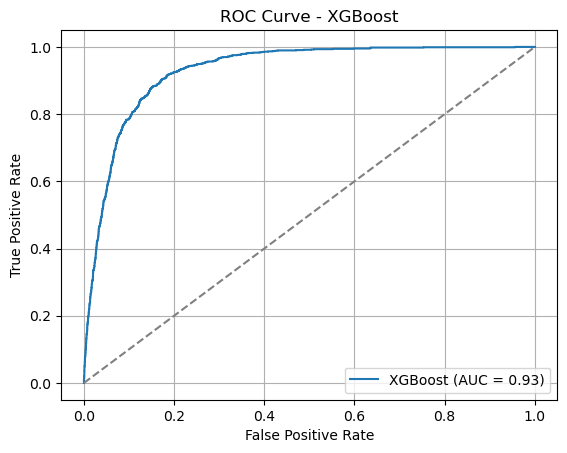

In [26]:
# ROC AUC
xgb_probs = xgb.predict_proba(X_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, xgb_probs))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, xgb_probs)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter tuning

In [28]:
# RandomizedSearchCV (XGBoost)

from sklearn.model_selection import RandomizedSearchCV
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    verbose=1, 
    n_jobs=-1,
    random_state=42
)
xgb_random.fit(X_train, y_train)
print("Best XGBoost Parameters:", xgb_random.best_params_)
best_xgb = xgb_random.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\Kunal T\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:19:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.8}


ROC AUC Score: 0.9327976723843028


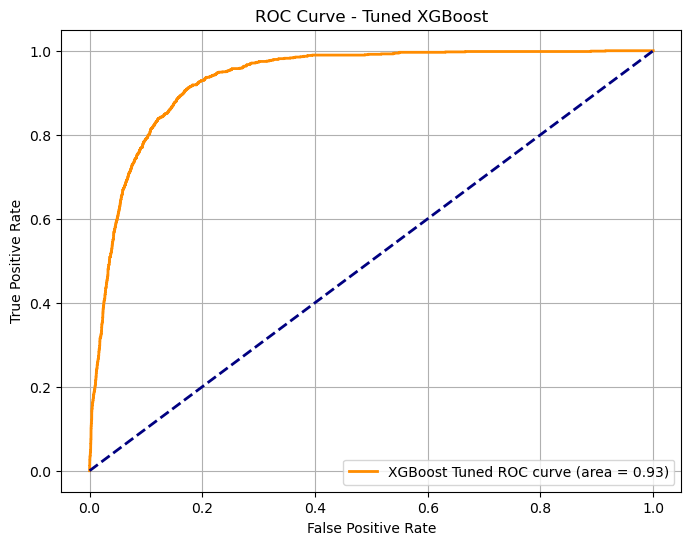

In [31]:
xgb_probs = best_xgb.predict_proba(X_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, xgb_probs))

fpr, tpr, _ = roc_curve(y_test, xgb_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost Tuned ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned XGBoost')
plt.legend(loc="lower right")
plt.grid()
plt.show()

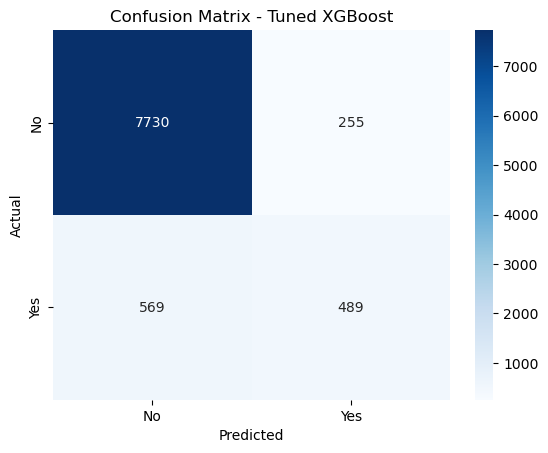

In [42]:
# heatmap of cm

cm = confusion_matrix(y_test, xgb_preds_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned XGBoost')
plt.show()

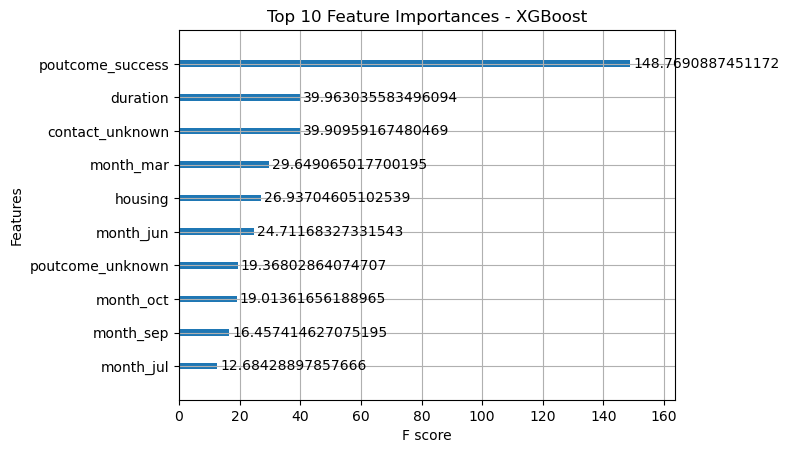

In [40]:
# Feature importance

from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(best_xgb, importance_type='gain', max_num_features=10)
plt.title("Top 10 Feature Importances - XGBoost")
plt.show()
